# Notebook 56: Core properties from MESA output

In [1]:
nb_id = 56

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor, as_completed

import mesa_reader as mr
import mesaPlot as mp

import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo

import sys
sys.path.append('..')
from src.util import Z_SUN, savefig_base, DATA_ROOT, MESA_DATA_ROOT

plt.style.use('./plotstyle.mplstyle')

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [3]:
Z_SUN

0.017

In [4]:
th = cosmo.age(0).to(u.yr).value

In [5]:
FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

def savefig(fig, fname):
    """Saves png, pdf and eps figure files to a nb-specific folder."""
    fname = f'nb{nb_id}_{fname}'
    plt.savefig(FIGURE_FOLDER/(fname+'.png'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.pdf'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.eps'), bbox_inches='tight')

In [6]:
def get_model_dict(grid_folder):
    """Given a model folder, loads the paths of specific stars into a 
    m1, p_orb dictionary."""
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        try:
            m, p, w = model_folder.name.replace('d', 'e').split('_')
            w = float(w.lstrip('w'))
            p = f'{float(p.lstrip("p")):.2f}'      
        except ValueError:
            m, w = model_folder.name.replace('d', 'e').split('_')   
            w = float(w.lstrip('w'))
            p = (2*np.pi/w) / (60*60*24)
        m = f'{float(m.lstrip("m")):.1f}'
        
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [7]:
def load_models(project_folder):
    model_folders = list(project_folder.glob('*_md*_m*_zsundiv*_*y0_*dy'))
    _model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
    model_dicts = dict()
    for dicts in _model_dicts:
        for m in dicts.keys():
            if m not in model_dicts.keys():
                model_dicts[m] = dicts[m]
    return model_dicts

## Data

In [8]:
project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/09_ZdivZsun_5d-4'
model_dicts_00005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/08_ZdivZsun_5d-3'
model_dicts_0005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/07_ZdivZsun_2d-2'
model_dicts_002zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/06_ZdivZsun_5d-2'
model_dicts_005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1'
model_dicts_01zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1'
model_dicts_02zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/02_ZdivZsun_4d-1'
model_dicts_04zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/03_ZdivZsun_6d-1'
model_dicts_06zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1'
model_dicts_08zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/05_ZdivZsun_1d0'
model_dicts_10zsun = load_models(project_folder)


In [9]:
all_model_dicts = {
    '0.0005': model_dicts_00005zsun,
    '0.005': model_dicts_0005zsun,
    '0.02': model_dicts_002zsun,
    '0.05': model_dicts_005zsun,
    '0.1': model_dicts_01zsun,
    '0.2': model_dicts_02zsun,
    '0.4': model_dicts_04zsun,
    '0.6': model_dicts_06zsun,
    '0.8': model_dicts_08zsun,
    '1.0': model_dicts_10zsun
}

final_core_prop_array_dict = {
    '0.0005': np.load(DATA_ROOT/'09_enhanced_w_core_props.npy'),
    '0.005': np.load(DATA_ROOT/'08_enhanced_w_core_props.npy'),
    '0.02': np.load(DATA_ROOT/'07_enhanced_w_core_props.npy'),
    '0.05': np.load(DATA_ROOT/'06_enhanced_w_core_props.npy'),
    '0.1': np.load(DATA_ROOT/'00_enhanced_w_core_props.npy'),
    '0.2': np.load(DATA_ROOT/'01_enhanced_w_core_props.npy'),
    '0.4': np.load(DATA_ROOT/'02_enhanced_w_core_props.npy'),
    '0.6': np.load(DATA_ROOT/'03_enhanced_w_core_props.npy'),
    '0.8': np.load(DATA_ROOT/'04_enhanced_w_core_props.npy'),
    '1.0': np.load(DATA_ROOT/'05_enhanced_w_core_props.npy')
}

## Properties

In [10]:
dict_ = all_model_dicts
z_keys = np.array(list(dict_.keys()))
z_keys = z_keys[z_keys.astype(float).argsort()]

dict_ = model_dicts_01zsun
m_keys = np.array(list(dict_.keys()))
m_keys = m_keys[m_keys.astype(float).argsort()]

dict_ = model_dicts_01zsun['300.0']
p_keys = np.array(list(dict_.keys()))
p_keys = p_keys[p_keys.astype(float).argsort()]

In [11]:
len(p_keys)

16

In [12]:
final_core_prop_array_dict['0.1'].shape

(16, 10, 12)

In [13]:
z_keys

array(['0.0005', '0.005', '0.02', '0.05', '0.1', '0.2', '0.4', '0.6',
       '0.8', '1.0'], dtype='<U6')

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


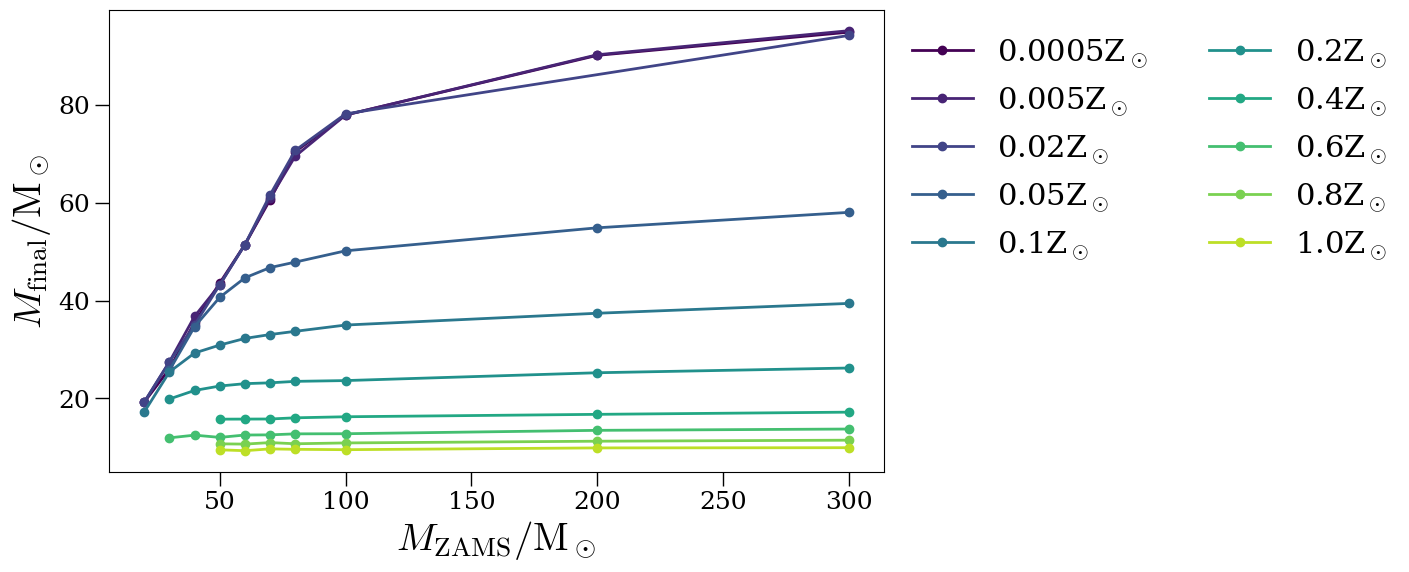

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
cmap = cm.viridis

for i_z, z_key in enumerate(z_keys):
    c = cmap(i_z/len(z_keys))
    
    X = []
    Y = []
    for i_m, m_key in enumerate(m_keys):
        m = float(m_key)
        y = []
                
        for i_p, p_key in enumerate(p_keys):      
            core_props = final_core_prop_array_dict[z_key][i_p, i_m]
            
            if core_props[9] and not core_props[8]:
                y.append(core_props[0])
        y = np.mean(y)
        X.append(m)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    X = X[~np.isnan(Y)]
    Y = Y[~np.isnan(Y)]
    Y = Y[~np.isnan(X)]
    X = X[~np.isnan(X)]
    if z_key == '0.4':
        X = X[1:]
        Y = Y[1:]
    ax.plot(X, Y, '-o', label=f'{z_key}Z$_\odot$', color=c, lw=2)
    
ax.set_xlabel('$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_ylabel('$M_\\mathrm{final}/\\mathrm{M}_\\odot$')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2)

savefig(fig, 'mzams_mfinal_scatter')

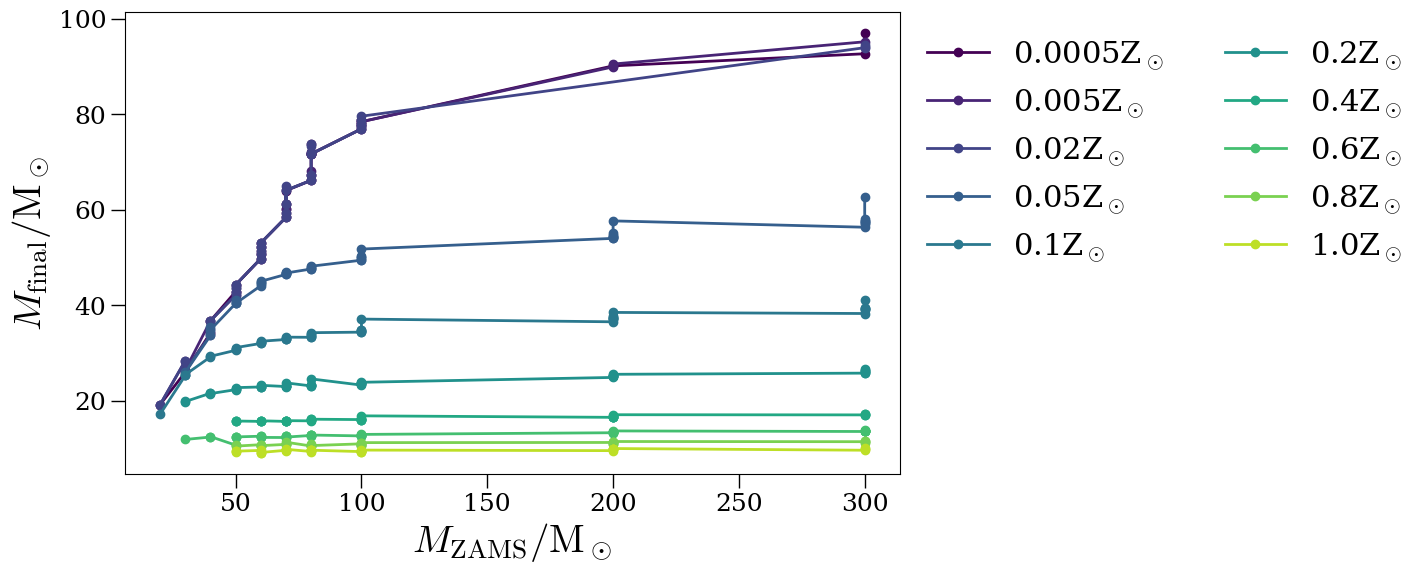

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
cmap = cm.viridis

for i_z, z_key in enumerate(z_keys):
    c = cmap(i_z/len(z_keys))
    
    X = []
    Y = []
    for i_m, m_key in enumerate(m_keys):
        m = float(m_key)                
        for i_p, p_key in enumerate(p_keys):      
            core_props = final_core_prop_array_dict[z_key][i_p, i_m]
            
            if core_props[9] and not core_props[8]:
                Y.append(core_props[0])
                X.append(m)
    X = np.array(X)
    Y = np.array(Y)
    X = X[~np.isnan(Y)]
    Y = Y[~np.isnan(Y)]
    Y = Y[~np.isnan(X)]
    X = X[~np.isnan(X)]
    if z_key == '0.4':
        X = X[1:]
        Y = Y[1:]
    ax.plot(X, Y, '-o', label=f'{z_key}Z$_\odot$', color=c, lw=2)
    
ax.set_xlabel('$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_ylabel('$M_\\mathrm{final}/\\mathrm{M}_\\odot$')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2)

savefig(fig, 'mzams_mfinal_allp_scatter')

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


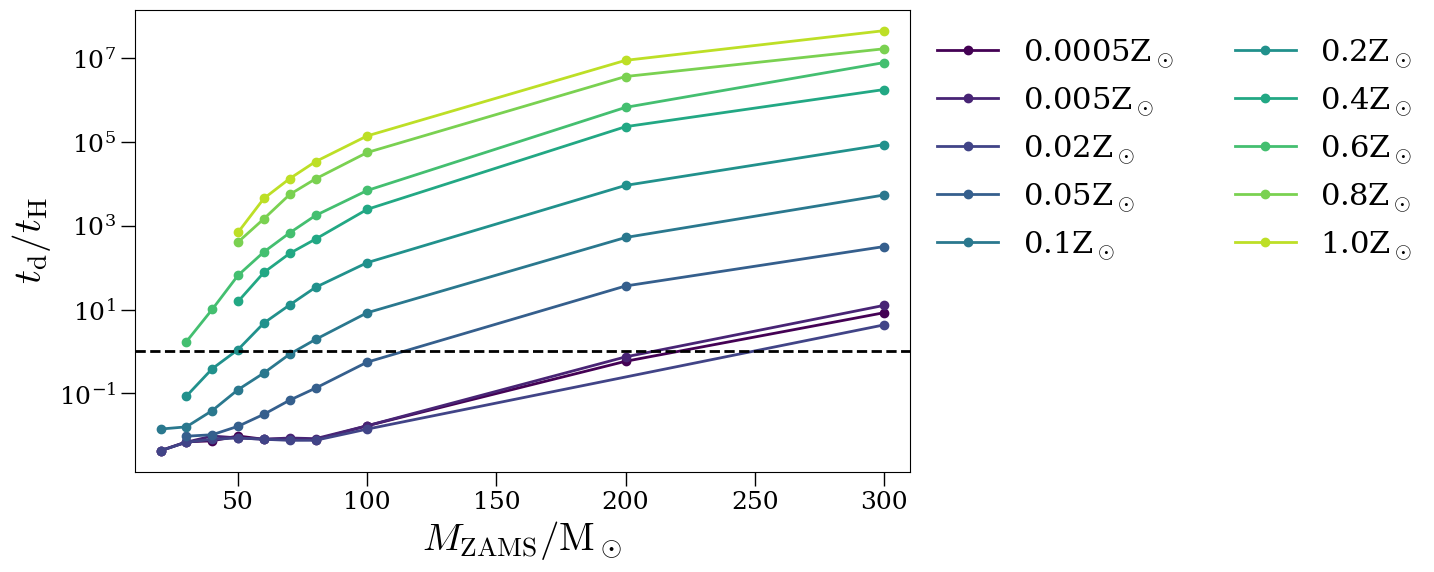

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
cmap = cm.viridis

for i_z, z_key in enumerate(z_keys):
    c = cmap(i_z/len(z_keys))
    
    X = []
    Y = []
    for i_m, m_key in enumerate(m_keys):
        m = float(m_key)
        y = []
        for i_p, p_key in enumerate(p_keys):      
            core_props = final_core_prop_array_dict[z_key][i_p, i_m]
            
            if core_props[9] and not core_props[8]:
                y.append(core_props[-1])
        y = np.mean(y)
        X.append(m)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    X = X[~np.isnan(Y)]
    Y = Y[~np.isnan(Y)]
    Y = Y[~np.isnan(X)]
    X = X[~np.isnan(X)]
    if z_key == '0.4':
        X = X[1:]
        Y = Y[1:]
    ax.plot(X, Y/th, '-o', label=f'{z_key}Z$_\odot$', color=c, lw=2)
    
ax.set_xlabel('$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_ylabel('$t_\\mathrm{d}/t_\\mathrm{H}$')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
ax.set_yscale('log')
ax.hlines(1, 10, 310, color='k', ls='--')
ax.set_xlim(10, 310)

savefig(fig, 'mzams_td_scatter')

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


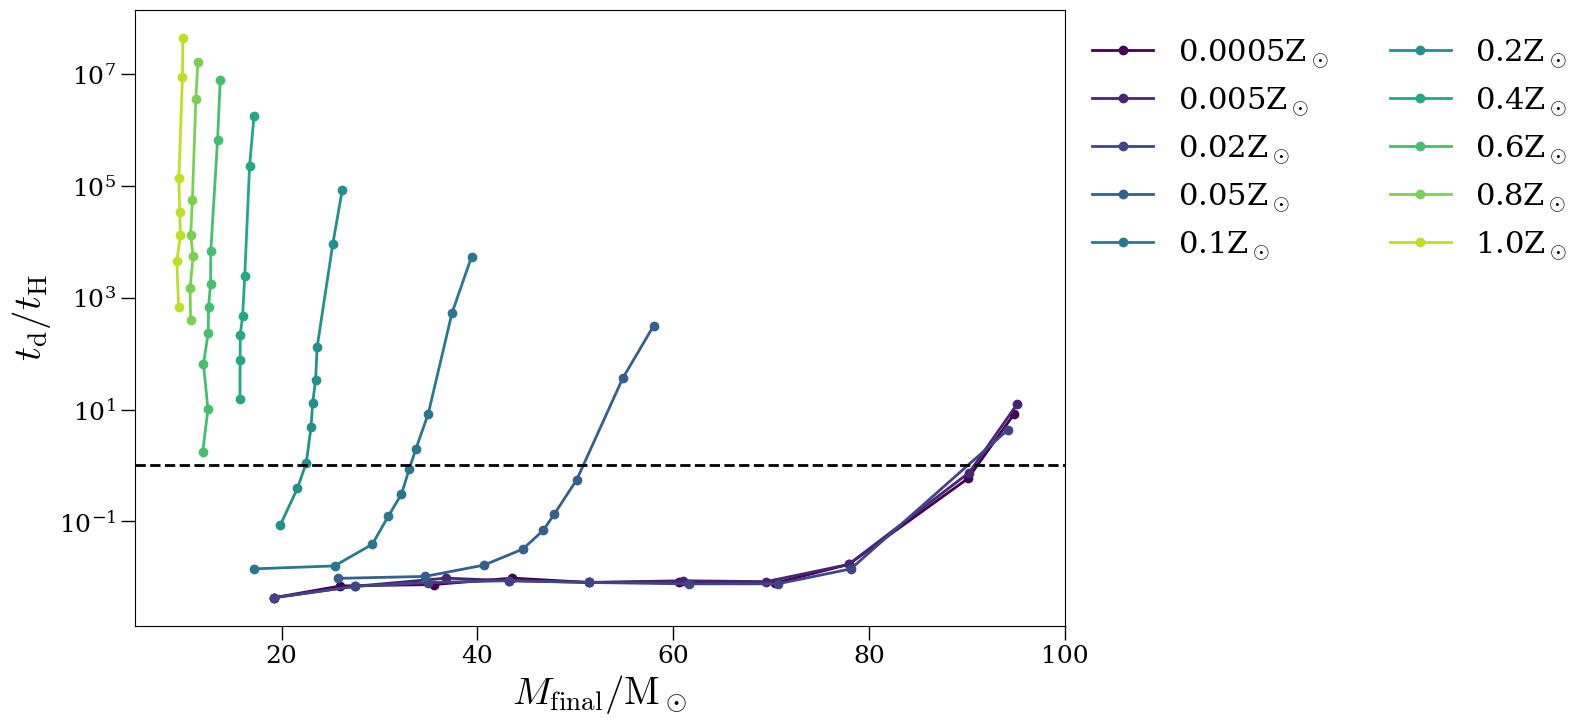

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
cmap = cm.viridis

for i_z, z_key in enumerate(z_keys):
    c = cmap(i_z/len(z_keys))
    
    X = []
    Y = []
    for i_m, m_key in enumerate(m_keys):
        m = float(m_key)
        y = []
        x = []
        for i_p, p_key in enumerate(p_keys):      
            core_props = final_core_prop_array_dict[z_key][i_p, i_m]
            
            if core_props[9] and not core_props[8]:
                y.append(core_props[-1])
                x.append(core_props[0])
        y = np.mean(y)
        x = np.mean(x)
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    X = X[~np.isnan(Y)]
    Y = Y[~np.isnan(Y)]
    Y = Y[~np.isnan(X)]
    X = X[~np.isnan(X)]
    if z_key == '0.4':
        X = X[1:]
        Y = Y[1:]
    ax.plot(X, Y/th, '-o', label=f'{z_key}Z$_\odot$', color=c, lw=2)
    
ax.set_xlabel('$M_\\mathrm{final}/\\mathrm{M}_\\odot$')
ax.set_ylabel('$t_\\mathrm{d}/t_\\mathrm{H}$')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
ax.set_yscale('log')
ax.hlines(1, 5, 100, color='k', ls='--')
ax.set_xlim(5, 100)

savefig(fig, 'mfinal_td_scatter')